## DSGE w. Feedback - Numerical Simulations

### Imports

In [1]:
%matplotlib notebook
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
import steadystate

## Simulation mechanics

In [5]:
def c_bound(z: float, k: float, p:dict):
    """Upper bound on the amount that can be consumed
    
    .. math:: c_t \leq z_t\cdotk_t\cdot\alpha^{-\frac{1}{\mu}}
    
    
    Parameters
    ----------
    z : float
        Level of productivity
    k : float
        Level of capital at t
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    return z * k * p['alpha'] ** (-1 / p['mu'])


def bisection(z:float, g:float, k:float, p:dict, precision:float=1e-7):
    """ Determine the level of consumption using the bisection method
    
    .. math:: \frac{2\gamma}{1-\alpha} c_t -  G_t z_t \left(c_t^{-\mu } z_t^{\mu }\right)^{-\frac{\mu +1}{\mu }} \left(\frac{c_t^{-\mu } z_t^{\mu }-\alpha  k_t^{-\mu }}{1-\alpha }\right)^{\frac{2}{\mu }+1} = 0
    
    
    Parameters
    ----------
    z : float
        Level of productivity
    g : float
        Consumption rate (% of income consumed)
    k : float
        Level of capital at t
    p : dict
        Parameters from simulation
    precision : float, default: 1e-5
        Precision of the bisection solution
    
    Returns
    -------
    c : float
        level of consumption
    """
    
    # Pre-compute constants
    mu = p['mu']
    lhs_1 = 2 * p['gamma'] / (1 - p['alpha'])
    rhs_1 = g * z / ((1 - p['alpha']) ** (2 / mu + 1))
    rhs_2 = p['alpha'] * k ** (-1 * mu)
    
    # Minimisation target for the bisection
    def diff(c: float):
        r = z / c
        rhs = rhs_1 * (r ** (-1 - mu)) * ((r ** mu) - rhs_2) ** (2 / mu + 1)
        return c * lhs_1 - rhs
    
    max_val = c_bound(z, k, p)
    
    # Adapt by precision to avoid asymptotic bounds
    edge = precision * 1e-2
    x = [edge, max_val / 2, max_val-edge]
    abs_lst = [abs(diff(i)) for i in x[:2]]

    # Conditions to stop: difference too small OR too close to the bound
    while all([min(abs_lst) >= precision, max_val - x[0] >= precision]):
        test = np.sign([diff(i) for i in x])
        if test[0] == test[1]:
            x = [x[1], (x[1] + x[2]) / 2, x[2]]
        elif test[1] == test[2]:
            x = [x[0], (x[0] + x[1]) / 2, x[1]]     
        
        abs_lst = [abs(diff(i)) for i in x[:2]]

    return x[np.argmin(abs_lst)]

In [6]:
def step(t: float, x: np.ndarray, p: dict, err:float):
    """Iteration of one step in the simulation
    
    Parameters
    ----------
    t : float
        Current timestep t
    x : np.ndarray
        state variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, g_, s_, news_, inc_, xiz_, xin_ = x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
    
    # Observe "State of economy"
    g = g_
    s = s_
    #signal = np.tanh(p['s_theta'] * (s_ - p['s0']))
    #s = 0.5 * ((p['s_max'] - p['s_min']) * signal + (p['s_max'] + p['s_min']))

    # Determine Consumption
    c = bisection(z, g, k_, p)
    
    # Working hours via market clearing
    n = ((c / z) ** (-1 * p['mu']) - p['alpha'] * k_ ** (-1 * p['mu']))
    n = (n / (1 - p['alpha'])) ** (-1 / p['mu'])
    
    # Firm observes desired working hours, sets the wage accordingly
    rho = -1 * p['mu']
    temp = (p['alpha'] * k_ ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (rho - 1))
    
    # Income
    income = w * n + (b_  + q_ * k_) / (1 + p['inflation'])
    
    # Investment & Bonds
    investment = income * (1 - g)
    b = (1 + p['interest']) * s * investment
    
    # Capital & Risky return
    k = (1 - p['depreciation']) * k_ + investment * (1 - s)
    q = p['alpha'] * z * temp * (k ** (rho - 1))
    
    # Retain previous news formula out of interest
    xin = np.random.normal(0, p['sigmaN'])
    info = p['n_cons']*(c/c_ - 1)
    step_news = p['n_persistence'] * news_ + (1 - p['n_persistence']) * info + xin
    news = np.tanh(p['n_theta'] * step_news)
    s0 = (c/c_ - 1)
    
    return z, c, n, b, w, k, q, g, s, news, income, xiz, xin

In [7]:
def simulate(start: np.ndarray, p: dict, t_end: float = 1e3, err:float=1e-4):
    """ Complete a t_end period simulation of the whole system
    
    Parameters
    ----------
    start : np.ndarray
        starting variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
    t_end : float
        Duration of the simulation
        
    Returns
    -------
    df : pd.DataFrame
        timeseries of the simulation results
    """
    x = np.empty((int(t_end), len(start)))
    x[0, :] = start
    for t in range(1, int(t_end)):
        x[t, :] = step(t, x[t - 1, :], p, err)
        if any([x[t,1]<err, x[t,2]<err, x[t,5]<err]): # c, n, k
            break
    x = x[:t+10,:]
    cols = ['z', 'c', 'n', 'b', 'w', 'k', 'q', 'g', 's', 'news', 'income', 'xiz', 'xin']
    df = pd.DataFrame(x, columns=cols)
    df.loc[:,'inv'] = 100 * (1-df.loc[:,'g'])
    df.loc[:,'bc'] = df.b / df.c
    df.loc[:,'crisis'] = 0.5 * (1.1 + np.sign(df.n - df.k))
    df.loc[:,'utility'] = np.log(df.c) - p['gamma'] * (df.n ** 2)
    return df

----
## Interactive Analysis

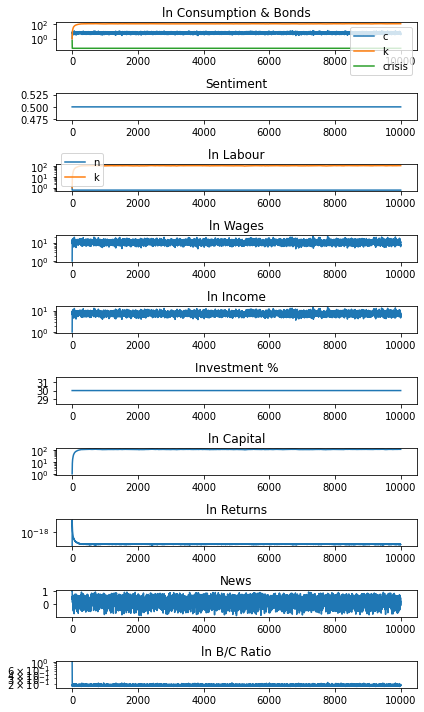

In [8]:
%matplotlib inline
params = {'etaZ': 0.2, 'sigmaZ': 0.2, 'zbar': 10.0, 'sigmaN': 0.2, 
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.01, 
          'g_min': 0.9, 'g_max': 1-1e-4, 
          's_min': 1e-4, 's_max': 1-1e-4,'s_theta':5, 's0':0.5,
          'n_cons': 10, 'n_theta': 1, 'n_persistence': 0.9, 
          'gamma': 1.0, 'alpha': 0.33, 'mu': 12.32}

start = dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.0, g=0.7, s=0.5, income=1, news=1, xiz=0, xin=0)
start = np.array([v for _,v in start.items()])

T = 10000
np.random.seed(40)
view = (0,T)


df = simulate(start, params, T)
df = df.iloc[view[0]:view[1],:]

graphs = {
        'ln Consumption & Bonds' : [df.loc[:,['c','k','crisis']], True],
        'Sentiment' : [df.s, False],
        'ln Labour' : [df.loc[:,['n','k']], True],
        'ln Wages' : [df.w, True],
        'ln Income' : [df.income, True],
        'Investment %' : [df.inv, False],
        'ln Capital' : [df.loc[:,['k']], True],
        'ln Returns' : [df.q, True],
        'News' : [df.news, False],
        'ln B/C Ratio' : [df.bc, True],
    }


axs = steadystate.simulation_graph(graphs, size = (6, 10))
#plt.show()
#plt.savefig('/Users/fedemoro/Desktop/test.jpg', format = 'jpg', dpi = 300)

-----
# Steady State Effects of Parameter variations

In [9]:
import steadystate

In [10]:
kwargs = dict(gs_num=10, T=2e3, err=1e-4, 
              macro_vars=['c', 'n', 'b', 'k', 'q', 'w', 'utility'],
              params={'etaZ': 0.2, 'sigmaZ': 0.0, 'zbar': 1.0, 'sigmaN': 0.2, 
                      'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.04, 
                      'g_min': 0.9, 'g_max': 1-1e-4, 's_min': 0.5, 's_max': 1, 
                      'n_cons': 10, 'n_theta': 1, 'n_persistence': 0.9, 
                      'gamma': 1.0, 'alpha': 0.33, 'mu': 0.32}, 
              start_dict=dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.0, g=0.7, s=0.5, income=1, news=1, xiz=0, xin=0))

In [13]:
ss_mu = steadystate.sim_param_effect('mu', [1e-2, 1, 5], **kwargs)

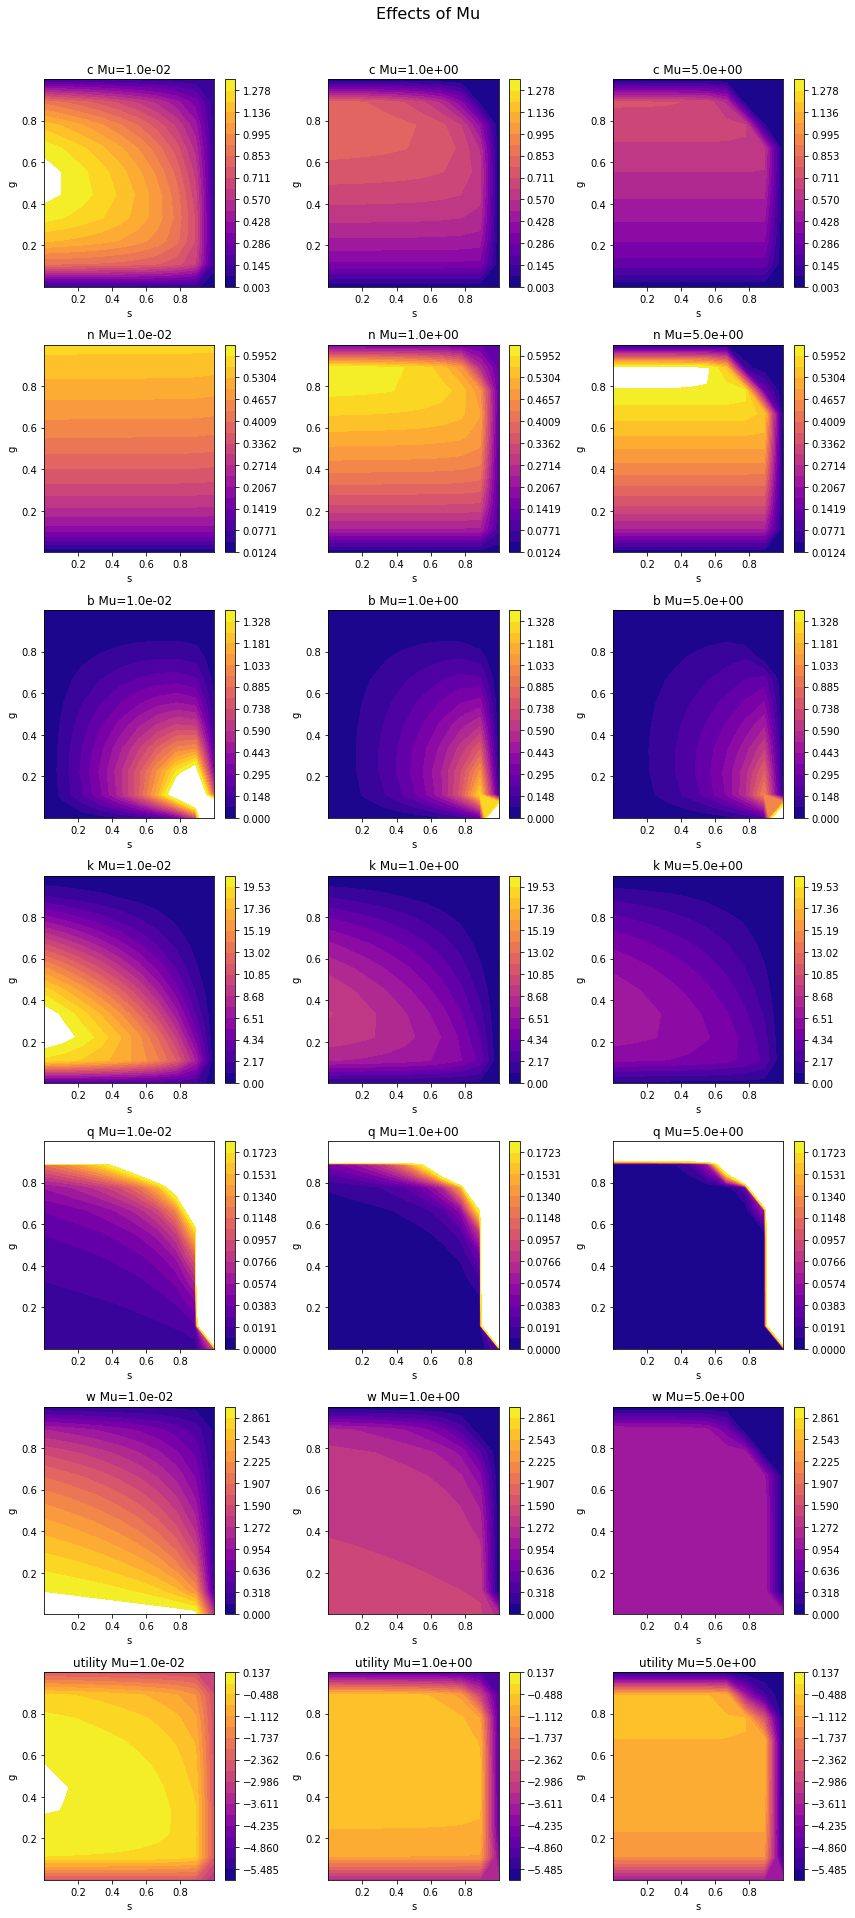

In [27]:
steadystate.plot_steady_state_effects(ss_mu, 'Mu', save='fig_steady_state_effects_rho.pdf', 
                                      sup_tit='Effects of Mu', n_lin = 20, 
                                      top_cutoff=0.9, q_cutoff=0.75, cmap = 'plasma')

### Variations in Interest

In [ ]:
gs_num = 20
ss_r = sim_param_effect('interest', [1e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1], gs_num, T, err, macro_vars, params)
plot_steady_state_effects(ss_r, save='fig_steady_state_effects_r.pdf', sup_tit='Effects of the Interest Rate')

### Variations in Alpha

In [ ]:
gs_num = 20
ss_a = sim_param_effect('alpha', [1e-2, 1e-1, 2e-1, 5e-1, 7e-1], gs_num, T, err, macro_vars, params)
plot_steady_state_effects(ss_a, save='fig_steady_state_effects_alpha.pdf', sup_tit='Effects of Alpha')